In [1]:
%load_ext autoreload
%autoreload 2

# Get a book

In [2]:
import ipywidgets as widgets
opt_books = widgets.Dropdown(description='books', options=[
    ('A Study in Scarlet (en)', 244), 
    ('Pride and Prejudice (en)', 1342),
    ('Les Misérables (en)', 135),
    ('Buddenbrooks: Verfall einer Familie (de)', 34811),
    ('Les trois mousquetaires (fr)', 13951),
    ('Bajki (pl)', 27729),
    ('Buddah (zn)', 23585)
])
display(opt_books);

Dropdown(description='books', options=(('A Study in Scarlet (en)', 244), ('Pride and Prejudice (en)', 1342), (…

In [3]:
from utils.gutenberg import get_book

book = get_book(opt_books.value)

# Split text into smaller parts

For longer text documents, like those found in Project Gutenberg, it's not practical to use them in their entirety for retrieval and training large language models. Therefore, it's essential to divide them into smaller pieces. However, this process should strike a balance between the size (number of tokens) and the semantic coherence of these smaller segments. Smaller splits can result in numerous fragmented but semantically related pieces, while larger splits may obscure the document's semantics. Achieving the right balance is crucial for effective document processing and understanding.

## Splitting along words

In [4]:
from langchain.schema.document import Document
from langchain.text_splitter import (
    TextSplitter, CharacterTextSplitter, RecursiveCharacterTextSplitter, NLTKTextSplitter, SpacyTextSplitter,
    Language
)

# turn off warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

# split and print results
def split_and_print(book: Document, splitter: TextSplitter, print_parts: list[int] = None):
    parts = splitter.split_text(book.page_content)
    print(f'document length: {len(book.page_content)}')
    print(f' document parts: {len(parts)}')
    print(f'   sum of parts: {sum([len(part) for part in parts])}')
    print(f' parts overhead: {sum([len(part) for part in parts]) / len(book.page_content)}')
    print(f'avg part length: {sum([len(part) for part in parts]) / len(parts)}\n')

    print(f'first 10 parts:')

    for part in parts[:10]:
        print(repr(part))
    for part in (print_parts or []):
        print(f'\n\npart {part}:\n{parts[part]}')

In [5]:
text_splitter = CharacterTextSplitter(        
    separator = " ",
    chunk_size = 1000,
    chunk_overlap  = 200,
    add_start_index = True
)

split_and_print(book, text_splitter, [5,6])

document length: 239369
 document parts: 299
   sum of parts: 297818
 parts overhead: 1.2441794885720374
avg part length: 996.0468227424749

first 10 parts:
'A STUDY IN SCARLET\n\nBy A. Conan Doyle\n\n\n\n\nCONTENTS\n\nA STUDY IN SCARLET.\n\nPART I.\nCHAPTER I. MR. SHERLOCK HOLMES.\nCHAPTER II. THE SCIENCE OF DEDUCTION.\nCHAPTER III. THE LAURISTON GARDENS MYSTERY\nCHAPTER IV. WHAT JOHN RANCE HAD TO TELL.\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\nCHAPTER VI. TOBIAS GREGSON SHOWS WHAT HE CAN DO.\nCHAPTER VII. LIGHT IN THE DARKNESS.\n\nPART II. THE COUNTRY OF THE SAINTS\nCHAPTER I. ON THE GREAT ALKALI PLAIN.\nCHAPTER II. THE FLOWER OF UTAH.\nCHAPTER III. JOHN FERRIER TALKS WITH THE PROPHET.\nCHAPTER IV. A FLIGHT FOR LIFE.\nCHAPTER V. THE AVENGING ANGELS.\nCHAPTER VI. A CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\nCHAPTER VII. THE CONCLUSION.\n\n\n\n\nA STUDY IN SCARLET.\n\n\n\n\nPART I.\n\n\n(_Being a reprint from the Reminiscences of_ JOHN H. WATSON, M.D.,\n_Late of the

## Splitting along sentences

In [6]:
import nltk

texts = [
    "He always apologized to me for putting me to this inconvenience. “I have to use this room as a place of business,” he said, “and these people are my clients”. Again I had an opportunity of asking him a point blank question, and again my delicacy prevented me from forcing another man to confide in me.",
    "Dr. Watson will help you. We go to the U.S.A., i.e., not to Italy; Mrs. Hussey is there!",
    '''"A clam for supper? a cold clam; is THAT what you mean, Mrs. Hussey?" says I, "but that's a rather cold and clammy reception in the winter time, ain't it, Mrs. Hussey?"''',
    book.page_content[4205:5000]
]

for text in texts:
    for sent in nltk.sent_tokenize(text):
        print(f'{sent.strip()}\n---')


He always apologized to me for putting me to this inconvenience.
---
“I have to use this room as a place of business,” he said, “and these people are my clients”.
---
Again I had an opportunity of asking him a point blank question, and again my delicacy prevented me from forcing another man to confide in me.
---
Dr. Watson will help you.
---
We go to the U.S.A., i.e., not to Italy; Mrs. Hussey is there!
---
"A clam for supper?
---
a cold clam; is THAT what you mean, Mrs.
---
Hussey?"
---
says I, "but that's a rather cold and clammy reception in the winter time, ain't it, Mrs.
---
Hussey?"
---
In old days Stamford had
never been a particular crony of mine, but now I hailed him with
enthusiasm, and he, in his turn, appeared to be delighted to see me.
---
In
the exuberance of my joy, I asked him to lunch with me at the Holborn,
and we started off together in a hansom.
---
“Whatever have you been doing with yourself, Watson?” he asked in
undisguised wonder, as we rattled through the crowde

In [7]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")

texts = [
    "He always apologized to me for putting me to this inconvenience. “I have to use this room as a place of business,” he said, “and these people are my clients”. Again I had an opportunity of asking him a point blank question, and again my delicacy prevented me from forcing another man to confide in me.",
    "Dr. Watson will help you. We go to the U.S.A., i.e., not to Italy; Mrs. Hussey is there!",
    '''"A clam for supper? a cold clam; is THAT what you mean, Mrs. Hussey?" says I, "but that's a rather cold and clammy reception in the winter time, ain't it, Mrs. Hussey?"''',
    book.page_content[4205:5000]
]

for text in texts:
    for sent in nlp(text).sents:
        print(f'{str(sent).strip()}\n---')

He always apologized to me for putting me to this inconvenience.
---
“I have to use this room as a place of business,” he said, “and these people are my clients”.
---
Again I had an opportunity of asking him a point blank question, and again my delicacy prevented me from forcing another man to confide in me.
---
Dr. Watson will help you.
---
We go to the U.S.A., i.e., not to Italy; Mrs. Hussey is there!
---
"A clam for supper?
---
a cold clam; is THAT what you mean, Mrs. Hussey?" says I, "but that's a rather cold and clammy reception in the winter time, ain't it, Mrs. Hussey?"
---
In old days Stamford had
never been a particular crony of mine, but now I hailed him with
enthusiasm, and he, in his turn, appeared to be delighted to see me.
---
In
the exuberance of my joy, I asked him to lunch with me at the Holborn,
and we started off together in a hansom.
---
“Whatever have you been doing with yourself, Watson?”
---
he asked in
undisguised wonder, as we rattled through the crowded London

In [9]:
text_splitter = NLTKTextSplitter(
    separator = "\n\n",
    chunk_size = 1000,
    chunk_overlap  = 200,
    add_start_index = True
)

split_and_print(book, text_splitter, [4,5])

document length: 239369
 document parts: 300
   sum of parts: 278973
 parts overhead: 1.1654516666736294
avg part length: 929.91

first 10 parts:
'A STUDY IN SCARLET\n\nBy A. Conan Doyle\n\n\n\n\nCONTENTS\n\nA STUDY IN SCARLET.\n\nPART I.\n\nCHAPTER I. MR. SHERLOCK HOLMES.\n\nCHAPTER II.\n\nTHE SCIENCE OF DEDUCTION.\n\nCHAPTER III.\n\nTHE LAURISTON GARDENS MYSTERY\nCHAPTER IV.\n\nWHAT JOHN RANCE HAD TO TELL.\n\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\n\nCHAPTER VI.\n\nTOBIAS GREGSON SHOWS WHAT HE CAN DO.\n\nCHAPTER VII.\n\nLIGHT IN THE DARKNESS.\n\nPART II.\n\nTHE COUNTRY OF THE SAINTS\nCHAPTER I.\n\nON THE GREAT ALKALI PLAIN.\n\nCHAPTER II.\n\nTHE FLOWER OF UTAH.\n\nCHAPTER III.\n\nJOHN FERRIER TALKS WITH THE PROPHET.\n\nCHAPTER IV.\n\nA FLIGHT FOR LIFE.\n\nCHAPTER V. THE AVENGING ANGELS.\n\nCHAPTER VI.\n\nA CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\n\nCHAPTER VII.\n\nTHE CONCLUSION.\n\nA STUDY IN SCARLET.\n\nPART I.\n\n(_Being a reprint from the Reminiscences of_ 

In [10]:
text_splitter = SpacyTextSplitter(
    separator = "\n\n",
    chunk_size = 1000,
    chunk_overlap  = 200,
    add_start_index = True
)

split_and_print(book, text_splitter, [4,5])

document length: 239369
 document parts: 304
   sum of parts: 284234
 parts overhead: 1.1874302854588523
avg part length: 934.9802631578947

first 10 parts:
'A STUDY IN SCARLET\n\nBy A. Conan Doyle\n\n\n\n\nCONTENTS\n\nA STUDY IN SCARLET.\n\n\n\nPART I.\nCHAPTER I. MR.\n\nSHERLOCK HOLMES.\n\n\nCHAPTER II.\n\nTHE SCIENCE OF DEDUCTION.\n\n\nCHAPTER III.\n\nTHE LAURISTON GARDENS MYSTERY\nCHAPTER IV.\n\nWHAT JOHN RANCE HAD TO TELL.\n\n\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\n\n\nCHAPTER VI.\n\nTOBIAS GREGSON SHOWS WHAT HE CAN DO.\n\n\nCHAPTER VII.\n\nLIGHT IN THE DARKNESS.\n\n\n\nPART II.\n\nTHE COUNTRY OF THE SAINTS\nCHAPTER I. ON THE GREAT ALKALI PLAIN.\n\n\nCHAPTER II.\n\nTHE FLOWER OF UTAH.\n\n\nCHAPTER III.\n\nJOHN FERRIER TALKS WITH THE PROPHET.\n\n\nCHAPTER IV.\n\nA FLIGHT FOR LIFE.\n\n\nCHAPTER V.\n\nTHE AVENGING ANGELS.\n\n\nCHAPTER VI.\n\nA CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\nCHAPTER VII.\n\nTHE CONCLUSION.\n\n\n\n\n\n\nA STUDY IN SCARLET.\n\n\n\n\n\n

## Splitting along content structure

The Gutenber documents have a good structure with empty lines between paragraphs, and several empty lines before chapters and parts. Let's split on chapters ignoring chunk size and overlap.

In [11]:
text_splitter = CharacterTextSplitter(        
    separator = "\n\n\n\n",
    chunk_size = 100,
    chunk_overlap  = 20,
    add_start_index = True
)

split_and_print(book, text_splitter, [])

document length: 239369
 document parts: 19
   sum of parts: 239279
 parts overhead: 0.9996240114634727
avg part length: 12593.631578947368

first 10 parts:
'A STUDY IN SCARLET\n\nBy A. Conan Doyle'
'CONTENTS\n\nA STUDY IN SCARLET.\n\nPART I.\nCHAPTER I. MR. SHERLOCK HOLMES.\nCHAPTER II. THE SCIENCE OF DEDUCTION.\nCHAPTER III. THE LAURISTON GARDENS MYSTERY\nCHAPTER IV. WHAT JOHN RANCE HAD TO TELL.\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\nCHAPTER VI. TOBIAS GREGSON SHOWS WHAT HE CAN DO.\nCHAPTER VII. LIGHT IN THE DARKNESS.\n\nPART II. THE COUNTRY OF THE SAINTS\nCHAPTER I. ON THE GREAT ALKALI PLAIN.\nCHAPTER II. THE FLOWER OF UTAH.\nCHAPTER III. JOHN FERRIER TALKS WITH THE PROPHET.\nCHAPTER IV. A FLIGHT FOR LIFE.\nCHAPTER V. THE AVENGING ANGELS.\nCHAPTER VI. A CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\nCHAPTER VII. THE CONCLUSION.'
'A STUDY IN SCARLET.'
'PART I.\n\n\n(_Being a reprint from the Reminiscences of_ JOHN H. WATSON, M.D.,\n_Late of the Army Medical Departm

But we can also split along paragraphs and merge them to bigger chunks

In [12]:
text_splitter = RecursiveCharacterTextSplitter(        
    separators = ["\n\n\n\n", "\n\n"],
    chunk_size = 100,
    chunk_overlap  = 20,
    add_start_index = True,
    keep_separator = False
)

split_and_print(book, text_splitter, [11, 12, 13, 14, 15])

document length: 239369
 document parts: 784
   sum of parts: 237763
 parts overhead: 0.9932906934481909
avg part length: 303.2691326530612

first 10 parts:
'A STUDY IN SCARLET\n\nBy A. Conan Doyle'
'CONTENTS\n\nA STUDY IN SCARLET.'
'PART I.\nCHAPTER I. MR. SHERLOCK HOLMES.\nCHAPTER II. THE SCIENCE OF DEDUCTION.\nCHAPTER III. THE LAURISTON GARDENS MYSTERY\nCHAPTER IV. WHAT JOHN RANCE HAD TO TELL.\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\nCHAPTER VI. TOBIAS GREGSON SHOWS WHAT HE CAN DO.\nCHAPTER VII. LIGHT IN THE DARKNESS.'
'PART II. THE COUNTRY OF THE SAINTS\nCHAPTER I. ON THE GREAT ALKALI PLAIN.\nCHAPTER II. THE FLOWER OF UTAH.\nCHAPTER III. JOHN FERRIER TALKS WITH THE PROPHET.\nCHAPTER IV. A FLIGHT FOR LIFE.\nCHAPTER V. THE AVENGING ANGELS.\nCHAPTER VI. A CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\nCHAPTER VII. THE CONCLUSION.'
'A STUDY IN SCARLET.'
'PART I.'
'\n(_Being a reprint from the Reminiscences of_ JOHN H. WATSON, M.D.,\n_Late of the Army Medical Department

If we mind the small paragraphs, we can also combine smaller paragraphs using larger chunk size

In [13]:
text_splitter = RecursiveCharacterTextSplitter(        
    separators = ["\n\n\n\n", "\n\n"],
    chunk_size = 1000,
    chunk_overlap  = 200,
    add_start_index = True
)

split_and_print(book, text_splitter, [5, 6])

document length: 239369
 document parts: 297
   sum of parts: 248783
 parts overhead: 1.0393284009207542
avg part length: 837.6531986531986

first 10 parts:
'A STUDY IN SCARLET\n\nBy A. Conan Doyle\n\n\n\n\nCONTENTS\n\nA STUDY IN SCARLET.\n\nPART I.\nCHAPTER I. MR. SHERLOCK HOLMES.\nCHAPTER II. THE SCIENCE OF DEDUCTION.\nCHAPTER III. THE LAURISTON GARDENS MYSTERY\nCHAPTER IV. WHAT JOHN RANCE HAD TO TELL.\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\nCHAPTER VI. TOBIAS GREGSON SHOWS WHAT HE CAN DO.\nCHAPTER VII. LIGHT IN THE DARKNESS.\n\nPART II. THE COUNTRY OF THE SAINTS\nCHAPTER I. ON THE GREAT ALKALI PLAIN.\nCHAPTER II. THE FLOWER OF UTAH.\nCHAPTER III. JOHN FERRIER TALKS WITH THE PROPHET.\nCHAPTER IV. A FLIGHT FOR LIFE.\nCHAPTER V. THE AVENGING ANGELS.\nCHAPTER VI. A CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\nCHAPTER VII. THE CONCLUSION.\n\n\n\n\nA STUDY IN SCARLET.\n\n\n\n\nPART I.\n\n\n(_Being a reprint from the Reminiscences of_ JOHN H. WATSON, M.D.,\n_Late of the

### Other structures

This also works for other document types, like python code or markdown syntax

In [14]:
# read file ./utils/gutenberg.py

def read_file(file_name):
    with open(file_name, 'r') as f:
        return f.read()

text_splitter = RecursiveCharacterTextSplitter(        
    separators = ['\nclass', '\ndef'],
    chunk_size = 100,
    chunk_overlap  = 0,
    add_start_index = True,
)

code = Document(page_content=read_file('./utils/gutenberg.py'))
split_and_print(code, text_splitter, [2])

document length: 5443
 document parts: 9
   sum of parts: 5443
 parts overhead: 1.0
avg part length: 604.7777777777778

first 10 parts:
'from IPython.display import Markdown, display\nfrom tabulate import tabulate\nfrom urllib.request import urlopen\nfrom bs4 import BeautifulSoup\nfrom langchain.schema.document import Document\nimport os, json\n'
'\ndef load_text(book_id: int) -> str:\n    """\n    Load a book from the Gutenberg project.\n\n    :param book_id: The id of the book to load.\n    :return: The text of the book.\n    """\n    START_MARKERS = [\'*** START OF\']\n    END_MARKERS = [\'*** END OF\']\n\n    def _download(url: str) -> str:\n        print(f\'loading text from {url}\')\n        with urlopen(url) as response:\n            text = []\n            # ignore lines up to start markers\n            for line in response:\n                line = line.decode("utf-8-sig").strip()\n                if any(line.startswith(token) for token in START_MARKERS):\n                    br

### Do it Yourself

In [15]:
import re
from nltk.tokenize import sent_tokenize

text = book.page_content
raw_splits = [s.strip() for s in re.split('\n\n', text) if s]
splits = []
last = current = ""

for s in raw_splits[:30]:
    if len(s) < 200:
        current += "\n\n" + s
    else:
        splits.append(current.strip())
        current = sent_tokenize(last)[-1] + "\n\n" + s
    last = s
    

splits

['A STUDY IN SCARLET\n\nBy A. Conan Doyle\n\nCONTENTS\n\nA STUDY IN SCARLET.',
 'A STUDY IN SCARLET.\n\nPART I.\nCHAPTER I. MR. SHERLOCK HOLMES.\nCHAPTER II. THE SCIENCE OF DEDUCTION.\nCHAPTER III. THE LAURISTON GARDENS MYSTERY\nCHAPTER IV. WHAT JOHN RANCE HAD TO TELL.\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\nCHAPTER VI. TOBIAS GREGSON SHOWS WHAT HE CAN DO.\nCHAPTER VII. LIGHT IN THE DARKNESS.',
 'LIGHT IN THE DARKNESS.\n\nPART II. THE COUNTRY OF THE SAINTS\nCHAPTER I. ON THE GREAT ALKALI PLAIN.\nCHAPTER II. THE FLOWER OF UTAH.\nCHAPTER III. JOHN FERRIER TALKS WITH THE PROPHET.\nCHAPTER IV. A FLIGHT FOR LIFE.\nCHAPTER V. THE AVENGING ANGELS.\nCHAPTER VI. A CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\nCHAPTER VII. THE CONCLUSION.\n\nA STUDY IN SCARLET.\n\nPART I.\n\n(_Being a reprint from the Reminiscences of_ JOHN H. WATSON, M.D.,\n_Late of the Army Medical Department._)\n\nCHAPTER I.\nMR. SHERLOCK HOLMES.',
 'CHAPTER I.\nMR. SHERLOCK HOLMES.\n\nIn the year 1878 I to

In [16]:
import re

class CustomSplitter:
    def __init__(self):
        from nltk.tokenize import sent_tokenize
        self._tokenizer = sent_tokenize

    def split_text(self, text: str):
        def merge_small(in_splits):
            out_splits = []
            last_len = 0
            for s in in_splits:
                if out_splits and (len(s) < 200 or last_len < 200):
                    out_splits[-1].append(s)
                    last_len += len(s)
                else:
                    out_splits.append([s])
                    last_len = len(s)
            return out_splits
        
        def add_overlap(in_splits):
            def first_sentence(index):
                return [self._tokenizer(in_splits[index][0])[0]]
            def last_sentence(index):
                return [self._tokenizer(in_splits[index][-1])[-1]]        
            out_splits = [in_splits[0] + first_sentence(1)]
            for i in range(1, len(in_splits)-1):
                out_splits.append(last_sentence(i-1) + in_splits[i] + first_sentence(i+1))
            out_splits.append(last_sentence(len(in_splits)-2) + in_splits[len(in_splits)-1])
            return out_splits

        splits = [s.strip() for s in re.split('\n\n', text) if s]
        return ['\n\n'.join(s) for s in add_overlap(merge_small(splits))]

split_and_print(book, CustomSplitter(), [5,6,7])

document length: 239369
 document parts: 341
   sum of parts: 303645
 parts overhead: 1.2685226574869761
avg part length: 890.4545454545455

first 10 parts:
'A STUDY IN SCARLET\n\nBy A. Conan Doyle\n\nCONTENTS\n\nA STUDY IN SCARLET.\n\nPART I.\nCHAPTER I. MR. SHERLOCK HOLMES.\nCHAPTER II. THE SCIENCE OF DEDUCTION.\nCHAPTER III. THE LAURISTON GARDENS MYSTERY\nCHAPTER IV. WHAT JOHN RANCE HAD TO TELL.\nCHAPTER V. OUR ADVERTISEMENT BRINGS A VISITOR.\nCHAPTER VI. TOBIAS GREGSON SHOWS WHAT HE CAN DO.\nCHAPTER VII. LIGHT IN THE DARKNESS.\n\nPART II.'
'LIGHT IN THE DARKNESS.\n\nPART II. THE COUNTRY OF THE SAINTS\nCHAPTER I. ON THE GREAT ALKALI PLAIN.\nCHAPTER II. THE FLOWER OF UTAH.\nCHAPTER III. JOHN FERRIER TALKS WITH THE PROPHET.\nCHAPTER IV. A FLIGHT FOR LIFE.\nCHAPTER V. THE AVENGING ANGELS.\nCHAPTER VI. A CONTINUATION OF THE REMINISCENCES OF JOHN WATSON, M.D.\nCHAPTER VII. THE CONCLUSION.\n\nA STUDY IN SCARLET.\n\nPART I.\n\n(_Being a reprint from the Reminiscences of_ JOHN H. WATSON, M.

## Comparison

Soemtimes, splitting by structure leads to too large chunks. For better size control, we can add additional separators to `RecursiveCharacterTextSplitter`. The splitter is trying all separators in order to find a good split.

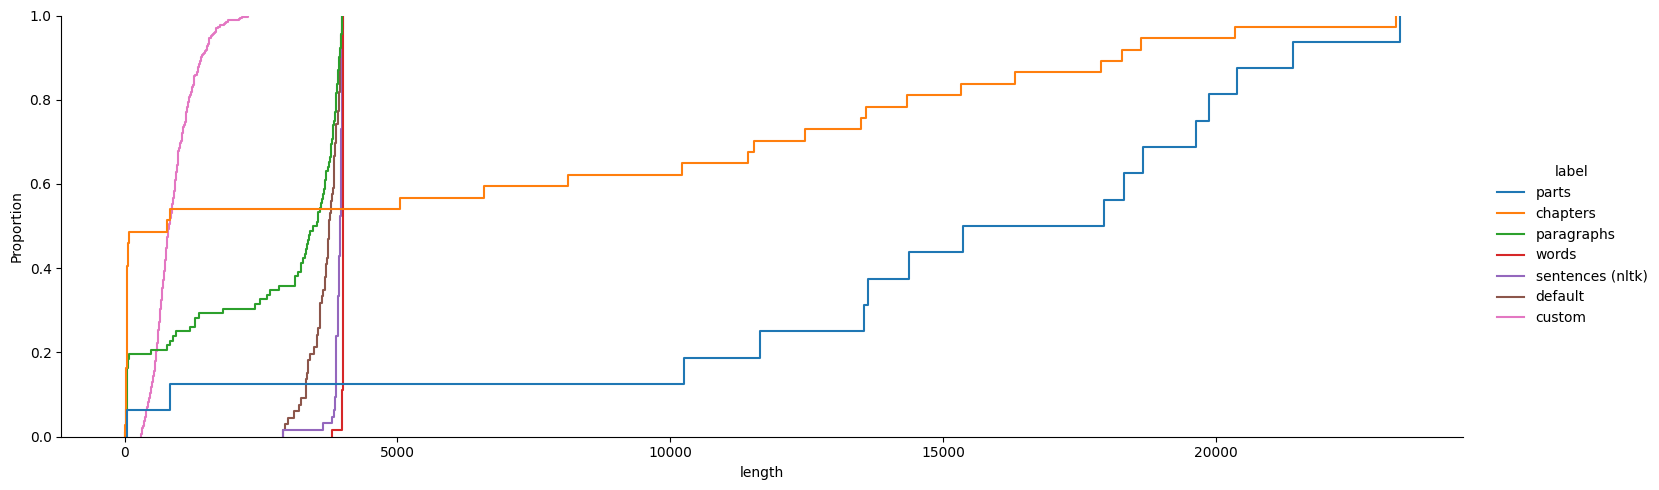

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

all = DataFrame()
params = {'chunk_size': 4000, 'chunk_overlap': 200}

def run_splitter(label: str, splitter: TextSplitter):
    global all
    parts = splitter.split_text(book.page_content)
    df = DataFrame([len(p) for p in parts], columns = ['length']).assign(label=label)
    all = pd.concat([all, df])

run_splitter('parts', CharacterTextSplitter(separator = "\n\n\n\n", **params))
run_splitter('chapters', RecursiveCharacterTextSplitter(separators = ["\n\n\n\n", "\n\n\n"], **params))
run_splitter('paragraphs', RecursiveCharacterTextSplitter(separators = ["\n\n\n\n", "\n\n\n", "\n\n"], **params))
run_splitter('words', CharacterTextSplitter(separator = " ", **params))
run_splitter('sentences (nltk)', NLTKTextSplitter(separator = " ", **params))
# run_splitter('sentences (spacy)', SpacyTextSplitter(separator = " ", **params))
run_splitter('default', RecursiveCharacterTextSplitter(**params))
run_splitter('custom', CustomSplitter())

sns.displot(all, x='length', kind="ecdf", hue="label", height=5, aspect=3);

## Deep dive yourself
Let's interact with a set of different splitters. You can add your own to see the results and compare with other methods.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
import ipywidgets as widgets
from IPython.display import display, Markdown

opt_splitter = widgets.Dropdown(description='splitter', options=['default', 'parts', 'chapters', 'paragraphs', 'sentences (nltk)', 'sentences (spacy)', 'words', 'custom'])
opt_size = widgets.BoundedIntText(description='size', min=500, max=50000, step=500, value=2000)
opt_overlap = widgets.BoundedIntText(description='overlap', min=0, max=2000, step=50, value=200)

# remove handlers if we re-execute this cell, need to do this before we overwrite function
try:
    opt_books.unobserve(change_book, 'value')
except: pass

def update_split(*args):
    global book, parts, splitter
    parts = splitter.split_text(book.page_content)
    if f_part.value == 0: f_part.value = 1
    f_part.value = 0
    f_part.max = len(parts) - 1
    df = DataFrame([len(p) for p in parts], columns = ['length'])
    out_stats.clear_output()
    with out_stats:
        display(Markdown(f'**splitter {opt_splitter.value} with chunk size {opt_size.value} and overlap {opt_overlap.value}**'))
        print(f'document length: {len(book.page_content)}')
        print(f' document parts: {len(parts)}')
        print(f'   sum of parts: {sum([len(part) for part in parts])}')
        print(f' parts overhead: {sum([len(part) for part in parts]) / len(book.page_content)}')
        print(f'avg part length: {sum([len(part) for part in parts]) / len(parts)}\n')
        # plt.figure(figsize=(10, 6), clear=True)
        sns.displot(df, x='length', bins=50, height=4, aspect=2)
        plt.show()

def change_splitter(*args):
    global splitter
    params = {'chunk_size': opt_size.value, 'chunk_overlap': opt_overlap.value}
    match opt_splitter.value:
        case 'default':
            splitter = RecursiveCharacterTextSplitter(**params)
        case 'parts':
            splitter = CharacterTextSplitter(separator = "\n\n\n\n\n", **params)
        case 'chapters':
            splitter = RecursiveCharacterTextSplitter(separators = ["\n\n\n\n", "\n\n\n"], **params)
        case 'paragraphs':
            splitter = RecursiveCharacterTextSplitter(separators = ["\n\n\n\n", "\n\n\n", "\n\n"], **params)
        case 'words':
            splitter = CharacterTextSplitter(separator = " ", **params)
        case 'sentences (nltk)':
            splitter = NLTKTextSplitter(separator = " ", **params)
        case 'sentences (spacy)':
            splitter = SpacyTextSplitter(separator = " ", **params)
        case 'custom':
            splitter = CustomSplitter()
    update_split()

def change_book(*args):
    global book
    book = get_book(opt_books.value)
    change_splitter()
    update_split()

def show_part(sort_by_len, part):
    global parts
    if sort_by_len:
        # find part-th longest part in parts array
        indexed_lengths = [(i, len(s)) for i, s in enumerate(parts)]
        sorted_lengths = sorted(indexed_lengths, key=lambda x: x[1])
        part = sorted_lengths[part][0]
    before = parts[part-1][-opt_overlap.value:] if part > 0 else ''
    after = parts[part+1][:opt_overlap.value] if part < (len(parts)-1) else ''
    text = Markdown(f"""
{before}
\n**---start of part {part} ({len(parts[part])} characters)---**\n
{parts[part]}   
\n**---end of part {part}---**\n
{after}
    """)
    display(text)

# observe changes
opt_books.observe(change_book, 'value')
opt_splitter.observe(change_splitter, 'value')
opt_size.observe(change_splitter, 'value')
opt_overlap.observe(change_splitter, 'value')

# display
form_data = widgets.GridBox([opt_books, opt_splitter, opt_size, opt_overlap], layout = {'margin': '0px 0px 20px', 'grid_template_columns': 'min-content min-content'})
out_stats = widgets.Output(layout = {'padding': '0px 50px', 'min_width': '60%'})
f_sorted = widgets.Checkbox(description='sorted by length', value=False)
f_part = widgets.BoundedIntText(description='part', min=0, max=50, step=1, value=0)
form_part = widgets.interactive(show_part, sort_by_len=f_sorted, part=f_part)
change_book()
display(widgets.VBox([form_data, widgets.HBox([form_part, out_stats])]))
